# Load components from file and connect them together if they share some 2-grams

In [1]:
import pandas as pd

In [63]:
import configparser
config = configparser.ConfigParser()
config.read('memeconfig.ini')
data_path = config['DEFAULT']['data_path']
pickle_data_path = config['DEFAULT']['pickle_data_path']
viz_path = config['DEFAULT']['viz_data_path']
series_name = 'baron_noir'

In [32]:
import numpy as np
import networkx as nx

In [67]:
def load_graph(filename):
    """ Load a graph from a json file.
    """
    from networkx.readwrite import json_graph
    import json
    with open(filename, "r") as f:
        data = json.load(f)
    # create a dic to translate ids to numbers for networkx
    dic_t = {}
    for idx,key in enumerate(data['nodes']):
        dic_t[key['id']] = idx
    # associate numbers to ids in links
    data['links'] = [
                {
                    'source': dic_t[link['source']],
                    'target': dic_t[link['target']]
                }
                for link in data['links']]
    H = json_graph.node_link_graph(data,directed=True,multigraph=False)
    return H

In [177]:
# Extract components
graph_list = []
year = 2016
for month in range(1,6):
    json_filename = 'cc_'+series_name+'_'+str(year)+'_'+str(month)+'.json'
    filename = viz_path + json_filename
    G = load_graph(filename)
    #print(G.size())
    list_cc = [cc for cc in nx.weakly_connected_component_subgraphs(G)]
    print('nb of cc: {}'.format(len(list_cc)))
    [graph_list.append(cc) for cc in list_cc]

nb of cc: 14
nb of cc: 65
nb of cc: 46
nb of cc: 9
nb of cc: 9


In [189]:
# Select the components
selected_graphs = []
keywords = ['El-Khomri','Khomri','travail','Hollande','Valls','Dray']
for idx,HH in enumerate(graph_list):
    double=0
    for node,data in HH.nodes(data=True):
        if data['name'] in keywords and double==0 and HH.size()>3:
            print(idx,data['name'])
            selected_graphs.append(HH)
            double=1

18 Valls
21 Valls
22 Khomri
24 Khomri
31 Dray
33 Hollande
35 Hollande
79 Dray
80 Hollande
82 travail
86 El-Khomri
88 El-Khomri
90 Dray
126 Valls
127 Valls
129 Dray


In [190]:
# Get the start date of a component
def cc_time(G):
    import datetime
    date_list = [data['start_time'] for node,data in G.nodes(data=True)]
    date_list = [datetime.datetime.strptime(x, '%d-%m-%Y') for x in date_list]
    #date_list = sorted(date_list, key=lambda x: datetime.datetime.strptime(x, '%d-%m-%Y'))
    date_list.sort()
    return date_list[0]

In [191]:
# sort the components per date
sorted_selectedg = sorted(selected_graphs, key=cc_time)

In [192]:
# Check the result
for gg in sorted_selectedg:
    print(cc_time(gg),gg.size())

2016-02-08 00:00:00 566
2016-02-09 00:00:00 85
2016-02-12 00:00:00 8
2016-02-19 00:00:00 16
2016-02-21 00:00:00 16
2016-02-24 00:00:00 46
2016-02-29 00:00:00 137
2016-03-01 00:00:00 92
2016-03-03 00:00:00 444
2016-03-04 00:00:00 95
2016-03-06 00:00:00 7
2016-03-08 00:00:00 7
2016-03-17 00:00:00 11
2016-04-10 00:00:00 12
2016-04-11 00:00:00 20
2016-04-12 00:00:00 7


In [193]:
import datetime

In [194]:
# Give a time stamp and connect cc if they have same node names
edge_list = []
start_date = cc_time(sorted_selectedg[0])
date_len = cc_time(sorted_selectedg[-1])-cc_time(sorted_selectedg[0])
for  idx,cc in enumerate(sorted_selectedg):
    datediff = cc_time(cc)-start_date
    datediff_norm = datediff.days/date_len.days
    nx.set_node_attributes(cc, 'time_loc', datediff_norm)
    if idx+1<len(sorted_selectedg):
        cc_next = sorted_selectedg[idx+1]
        for node1,data1 in cc.nodes(data=True):
            for node2,data2 in cc_next.nodes(data=True):
                if data1['name']==data2['name']:
                    if not node1==node2: # in case there is a component twice 
                        edge_list.append((node1,node2))  

In [195]:
edge_list

[('#BaronNoir_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  '#BaronNoir_09-02-2016_I0F1ZGllbmNlc18yMDE2LTAyLTA5LTA5'),
 ('politique_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  'politique_09-02-2016_I0F1ZGllbmNlc18yMDE2LTAyLTA5LTA5'),
 ('Baron_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  'Baron_09-02-2016_I0F1ZGllbmNlc18yMDE2LTAyLTA5LTA5'),
 ('première_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  'première_09-02-2016_I0F1ZGllbmNlc18yMDE2LTAyLTA5LTA5'),
 ('noir_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  'noir_09-02-2016_I0F1ZGllbmNlc18yMDE2LTAyLTA5LTA5'),
 ('Canal_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  'Canal_09-02-2016_I0F1ZGllbmNlc18yMDE2LTAyLTA5LTA5'),
 ('soir_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  'soir_09-02-2016_I0F1ZGllbmNlc18yMDE2LTAyLTA5LTA5'),
 ('Noir_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  'Noir_09-02-2016_I0F1ZGllbmNlc18yMDE2LTAyLTA5LTA5'),
 ('homme_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  'homme_09-02-2016_I0F1ZGllbmNlc18yMDE

In [196]:
# Add all the components in a big graph
G_all = nx.DiGraph()
for comp_cc in sorted_selectedg:
    G_all = nx.compose(G_all,comp_cc)

In [197]:
G_all.node['Baron_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2']

{'color': 0.2474820143884892,
 'color_rel': 0,
 'color_rel_full': 0.0,
 'component_id': 'I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
 'name': 'Baron',
 'nb_occur': 23,
 'start_time': '08-02-2016',
 'time_loc': 0.0}

In [198]:
G_all.add_edges_from(edge_list)

In [199]:
str(cc_time(sorted_selectedg[0]).date())

'2016-02-08'

In [200]:
# Save the data
G_all.graph['series_name'] = series_name
G_all.graph['start_date'] = str(cc_time(sorted_selectedg[0]).date())
G_all.graph['end_date'] = str(cc_time(sorted_selectedg[-1]).date())
import memebox.multilayergraph as mlg
jsonfile = 'viz/cc_evolution.json'
mlg.save_graph(G_all,jsonfile)

In [173]:
G_all.graph

{'date_delta': 'hour',
 'end_date': '2016-04-12',
 'name': '()',
 'series_name': 'baron_noir',
 'start_date': '2016-02-08',
 'threshold': '3'}

## tests

In [93]:
G_all.nodes(data=True)

[('thème_03-03-2016_IzMwYW5zQmFjUHJvXzIwMTYtMDMtMDMtMTQ=',
  {'color': 0.07806191117092867,
   'color_rel': 0,
   'color_rel_full': 0.2222222222222222,
   'component_id': 'IzMwYW5zQmFjUHJvXzIwMTYtMDMtMDMtMTQ=',
   'name': 'thème',
   'nb_occur': 4,
   'start_time': '03-03-2016'}),
 ('pouvoir_08-02-2016_I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
  {'color': 0.2517985611510791,
   'color_rel': 0,
   'color_rel_full': 0.13636363636363635,
   'component_id': 'I0Jhcm9uTm9pcl8yMDE2LTAyLTA4LTA2',
   'name': 'pouvoir',
   'nb_occur': 7,
   'start_time': '08-02-2016'}),
 ('mouvements_08-03-2016_QE1vbmRlc1BvbGl0aXF1ZV8yMDE2LTAzLTA4LTIy',
  {'color': 0.2503364737550471,
   'color_rel': 0,
   'color_rel_full': 0.0,
   'component_id': 'QE1vbmRlc1BvbGl0aXF1ZV8yMDE2LTAzLTA4LTIy',
   'name': 'mouvements',
   'nb_occur': 5,
   'start_time': '08-03-2016'}),
 ('habituellement_03-03-2016_IzMwYW5zQmFjUHJvXzIwMTYtMDMtMDMtMTQ=',
  {'color': 0.07806191117092867,
   'color_rel': 0,
   'color_rel_full': 0.2222222222222

<IPython.core.display.Javascript object>


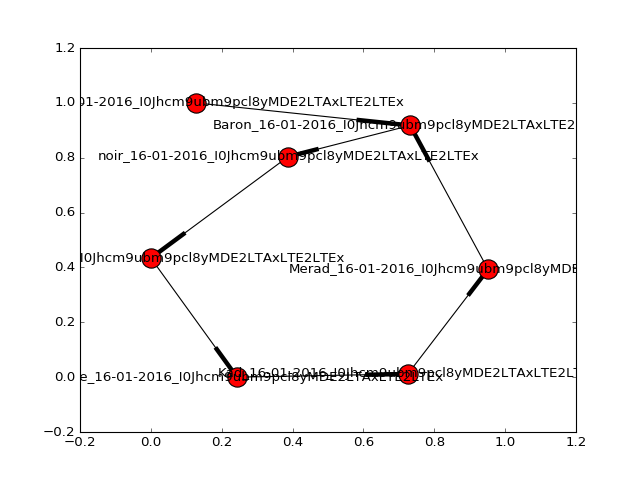

In [73]:
%matplotlib notebook
import matplotlib.pyplot as plt
nx.draw_networkx(HH)
plt.show()

In [ ]:
json_filename = filename
    if graph.size()!=0:
        data = json_graph.node_link_data(graph)
        #,attrs={'source': 'source', 'target': 'target','key': 'key', 'id': 'id', 'nb_occur':'nb_occur','start_time':'start_time','name':'name', 'color':'color'})#,'time_length':'time_length'})
        data['links'] = [
                {
                    'source': data['nodes'][link['source']]['id'],
                    'target': data['nodes'][link['target']]['id']
                }
                for link in data['links']]
        data['name'] = graph.graph['series_name']
        data['start_date'] = graph.graph['start_date']
        data['end_date'] = graph.graph['end_date']
        s = json.dumps(data)
        with open(filename, "w") as f:
            f.write(s)